#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Synthetic Features and Outliers

**Learning Objectives:**
  * Create a synthetic feature that is the ratio of two other features
  * Use this new feature as an input to a linear regression model
  * Improve the effectiveness of the model by identifying and clipping (removing) outliers out of the input data

Let's revisit our model from the previous First Steps with TensorFlow exercise. 

First, we'll import the California housing data into a *pandas* `DataFrame`:

## Setup

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
2873,-117.7,33.7,18.0,328.0,68.0,391.0,60.0,4.1,87.5
10370,-120.2,39.0,16.0,1463.0,264.0,54.0,26.0,5.0,206.3
4955,-118.1,34.1,20.0,3090.0,802.0,2109.0,738.0,3.4,192.5
14368,-122.1,37.6,18.0,4335.0,808.0,2041.0,734.0,3.5,331.6
3672,-117.9,33.8,19.0,1920.0,471.0,1413.0,432.0,4.0,147.5
...,...,...,...,...,...,...,...,...,...
16511,-122.6,38.0,36.0,1336.0,258.0,678.0,249.0,5.6,292.0
4103,-118.0,33.8,35.0,984.0,179.0,661.0,199.0,5.1,189.6
10475,-120.4,36.8,12.0,932.0,244.0,1043.0,243.0,1.4,54.3
12083,-121.4,38.6,33.0,2289.0,576.0,1100.0,503.0,2.2,95.7


Next, we'll set up our input function, and define the function for model training:

In [3]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [4]:
def train_model(learning_rate, steps, batch_size, input_feature):
  """Trains a linear regression model.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
      
  Returns:
    A Pandas `DataFrame` containing targets and the corresponding predictions done
    after training the model.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]].astype('float32')
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label].astype('float32')

  # Create input functions.
  training_input_fn = lambda: my_input_fn(my_feature_data, targets, batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
      metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
    
    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Create a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)
  
  return calibration_data

## Task 1: Try a Synthetic Feature

Both the `total_rooms` and `population` features count totals for a given city block.

But what if one city block were more densely populated than another? We can explore how block density relates to median house value by creating a synthetic feature that's a ratio of `total_rooms` and `population`.

In the cell below, create a feature called `rooms_per_person`, and use that as the `input_feature` to `train_model()`.

What's the best performance you can get with this single feature by tweaking the learning rate? (The better the performance, the better your regression line should fit the data, and the lower
the final RMSE should be.)

**NOTE**: You may find it helpful to add a few code cells below so you can try out several different learning rates and compare the results. To add a new code cell, hover your cursor directly below the center of this cell, and click **CODE**.

In [5]:
#
# YOUR CODE HERE
#
california_housing_dataframe["rooms_per_person"] = california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"] 

Training model...
RMSE (on training data):
  period 00 : 217.60
  period 01 : 198.84
  period 02 : 181.69


  period 03 : 166.09
  period 04 : 153.03
  period 05 : 143.04
  period 06 : 136.27


  period 07 : 132.26
  period 08 : 131.06
  period 09 : 130.84
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,183.9,207.3
std,84.8,116.0
min,41.5,15.0
25%,150.6,119.4
50%,181.0,180.4
75%,206.9,265.0
max,4046.0,500.0


Final RMSE (on training data): 130.84


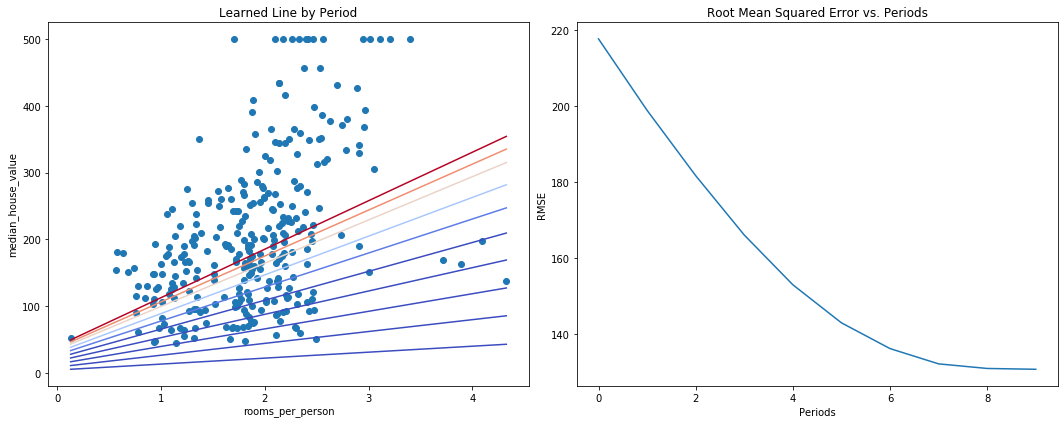

In [15]:
calibration_data = train_model(
    learning_rate=0.01,
    steps=2000,
    batch_size=5,
    input_feature="rooms_per_person"
)

### Solution

Click below for a solution.

In [10]:
california_housing_dataframe["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"])

Training model...
RMSE (on training data):
  period 00 : 212.75
  period 01 : 189.65
  period 02 : 169.75


  period 03 : 152.81
  period 04 : 141.31
  period 05 : 134.07
  period 06 : 131.60


  period 07 : 130.67
  period 08 : 131.76
  period 09 : 132.65
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,201.2,207.3
std,92.4,116.0
min,46.0,15.0
25%,164.9,119.4
50%,198.1,180.4
75%,226.3,265.0
max,4411.1,500.0


Final RMSE (on training data): 132.65


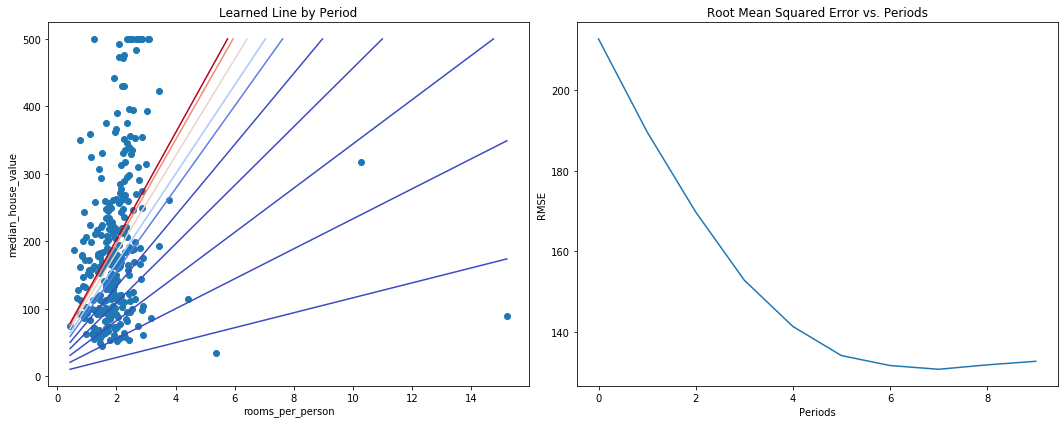

In [16]:
calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person")

## Task 2: Identify Outliers

We can visualize the performance of our model by creating a scatter plot of predictions vs. target values.  Ideally, these would lie on a perfectly correlated diagonal line.

Use Pyplot's [`scatter()`](https://matplotlib.org/gallery/shapes_and_collections/scatter.html) to create a scatter plot of predictions vs. targets, using the rooms-per-person model you trained in Task 1.

Do you see any oddities?  Trace these back to the source data by looking at the distribution of values in `rooms_per_person`.

In [17]:
calibration_data

,predictions,targets
0,221.1,66.9
1,542.1,80.1
2,233.1,85.7
3,237.4,73.4
4,193.5,65.5
...,...,...
16995,121.0,111.4
16996,142.3,79.0
16997,299.7,103.6
16998,261.7,85.8


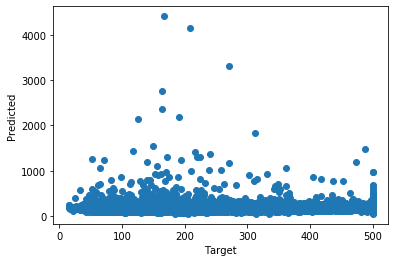

In [18]:
# YOUR CODE HERE
plt.scatter(calibration_data.targets, calibration_data.predictions)
plt.xlabel('Target')
plt.ylabel('Predicted')
plt.show()

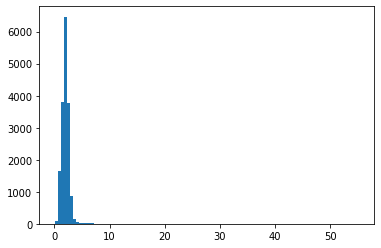

In [22]:
plt.hist(california_housing_dataframe.rooms_per_person,100)
plt.show()

### Solution

Click below for the solution.

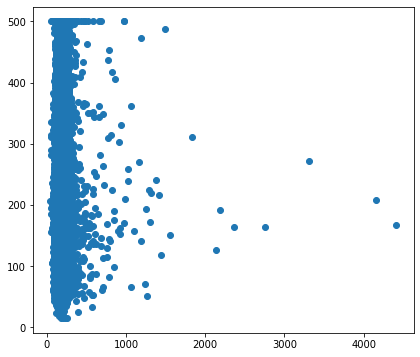

In [23]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(calibration_data["predictions"], calibration_data["targets"])

The calibration data shows most scatter points aligned to a line. The line is almost vertical, but we'll come back to that later. Right now let's focus on the ones that deviate from the line. We notice that they are relatively few in number.

If we plot a histogram of `rooms_per_person`, we find that we have a few outliers in our input data:

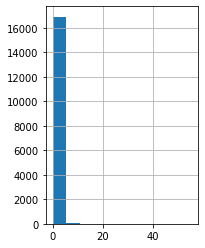

In [24]:
plt.subplot(1, 2, 2)
_ = california_housing_dataframe["rooms_per_person"].hist()

## Task 3: Clip Outliers

See if you can further improve the model fit by setting the outlier values of `rooms_per_person` to some reasonable minimum or maximum.

For reference, here's a quick example of how to apply a function to a Pandas `Series`:

    clipped_feature = my_dataframe["my_feature_name"].apply(lambda x: max(x, 0))

The above `clipped_feature` will have no values less than `0`.

In [6]:
california_housing_dataframe.rooms_per_person.describe()

count   17000.0
mean        2.0
std         1.2
min         0.0
25%         1.5
50%         1.9
75%         2.3
max        55.2
Name: rooms_per_person, dtype: float64

In [7]:
california_housing_dataframe["rooms_per_person"] = california_housing_dataframe["rooms_per_person"].apply(lambda x: min(x, 5))

In [8]:
california_housing_dataframe.rooms_per_person.describe()

count   17000.0
mean        1.9
std         0.7
min         0.0
25%         1.5
50%         1.9
75%         2.3
max         5.0
Name: rooms_per_person, dtype: float64

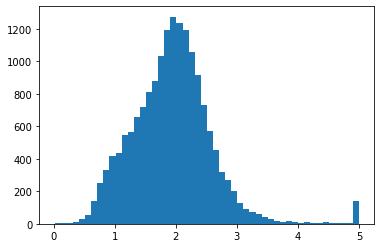

In [23]:
plt.hist(california_housing_dataframe.rooms_per_person,50)
plt.show()

Training model...
RMSE (on training data):
  period 00 : 154.46
  period 01 : 121.27
  period 02 : 113.66


  period 03 : 109.57
  period 04 : 108.24
  period 05 : 107.79
  period 06 : 107.70


  period 07 : 107.68
  period 08 : 107.68
  period 09 : 107.70
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,202.3,207.3
std,51.2,116.0
min,52.2,15.0
25%,169.6,119.4
50%,202.4,180.4
75%,230.2,265.0
max,441.3,500.0


Final RMSE (on training data): 107.70


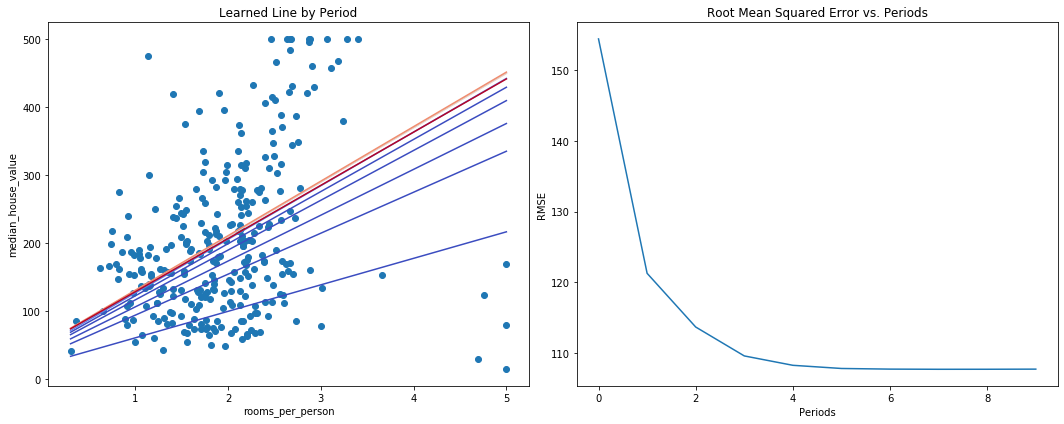

In [9]:
calibration_data = train_model(
    learning_rate=0.02,
    steps=5000,
    batch_size=1,
    input_feature="rooms_per_person"
)

In [25]:
len(calibration_data)

17000

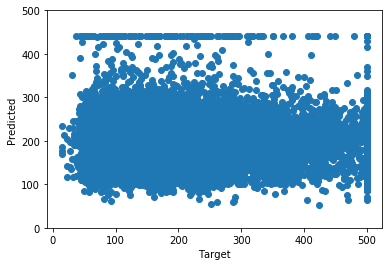

In [10]:
plt.scatter(calibration_data.targets, calibration_data.predictions)
plt.xlabel('Target')
plt.ylabel('Predicted')
plt.ylim([0,500])
plt.show()

### Solution

Click below for the solution.

The histogram we created in Task 2 shows that the majority of values are less than `5`. Let's clip `rooms_per_person` to 5, and plot a histogram to double-check the results.

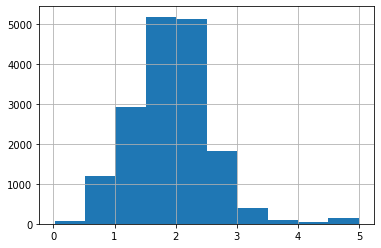

In [28]:
california_housing_dataframe["rooms_per_person"] = (
    california_housing_dataframe["rooms_per_person"]).apply(lambda x: min(x, 5))

_ = california_housing_dataframe["rooms_per_person"].hist()

To verify that clipping worked, let's train again and print the calibration data once more:

Training model...
RMSE (on training data):
  period 00 : 212.83
  period 01 : 189.06
  period 02 : 166.73


  period 03 : 146.54
  period 04 : 130.37
  period 05 : 119.08
  period 06 : 112.84


  period 07 : 109.45
  period 08 : 108.84
  period 09 : 108.02
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,198.3,207.3
std,52.1,116.0
min,45.6,15.0
25%,165.0,119.4
50%,198.3,180.4
75%,226.6,265.0
max,441.2,500.0


Final RMSE (on training data): 108.02


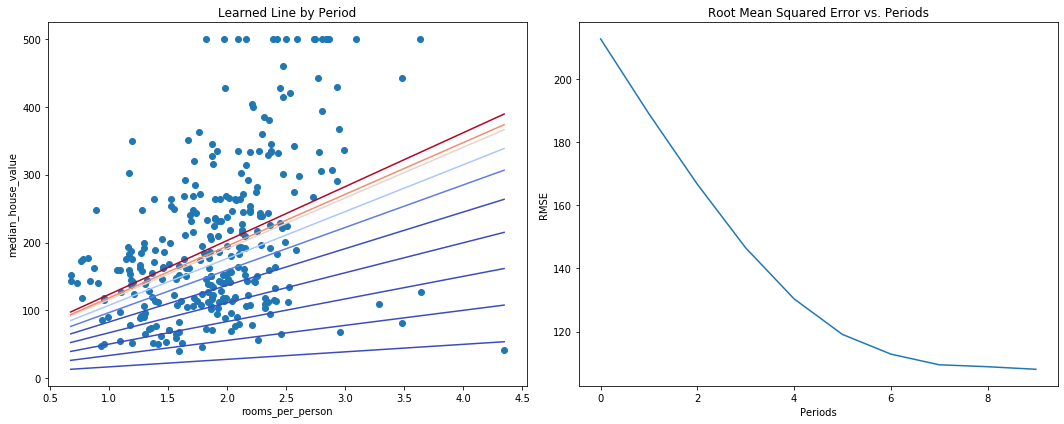

In [29]:
calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person")

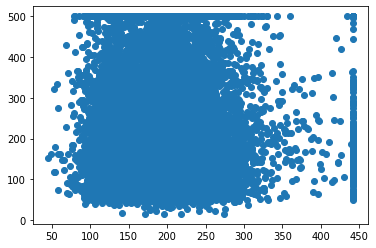

In [30]:
_ = plt.scatter(calibration_data["predictions"], calibration_data["targets"])